In [1]:
# import the necessary packages
from imutils import paths
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-6
EPOCHS = 25
BS = 64

In [3]:
DIRECTORY = r"C:\Users\adityakumarbisoyi\Desktop\26177 - No Face Mask Detection using Deep Learning\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
data = []
labels = []

In [5]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(128, 128))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)

In [8]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
# load the DenseNet121 network, ensuring the head FC layer sets are
# left off
baseModel = DenseNet121(include_top=False, input_tensor=Input(shape=(128, 128, 3)))

In [10]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 8, 8, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 8, 8, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 8, 8, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 4, 4, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 4, 4, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 4, 4, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 4, 4, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 4, 4, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 4, 4, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 4, 4, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 4, 4, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

In [13]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
# compile our model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [15]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    epochs=EPOCHS)

Epoch 1/25
63/63 [==============================] - 34s 334ms/step - loss: 1.6635 - accuracy: 0.5322 - val_loss: 0.6343 - val_accuracy: 0.7060
Epoch 2/25
63/63 [==============================] - 16s 252ms/step - loss: 0.8495 - accuracy: 0.6785 - val_loss: 0.3471 - val_accuracy: 0.8660
Epoch 3/25
63/63 [==============================] - 16s 257ms/step - loss: 0.5303 - accuracy: 0.7908 - val_loss: 0.2348 - val_accuracy: 0.9210
Epoch 4/25
63/63 [==============================] - 16s 258ms/step - loss: 0.3591 - accuracy: 0.8605 - val_loss: 0.1820 - val_accuracy: 0.9420
Epoch 5/25
63/63 [==============================] - 16s 261ms/step - loss: 0.2697 - accuracy: 0.8980 - val_loss: 0.1504 - val_accuracy: 0.9570
Epoch 6/25
63/63 [==============================] - 17s 264ms/step - loss: 0.2242 - accuracy: 0.9193 - val_loss: 0.1311 - val_accuracy: 0.9650
Epoch 7/25
63/63 [==============================] - 17s 264ms/step - loss: 0.2022 - accuracy: 0.9275 - val_loss: 0.1187 - val_accuracy: 0.9660

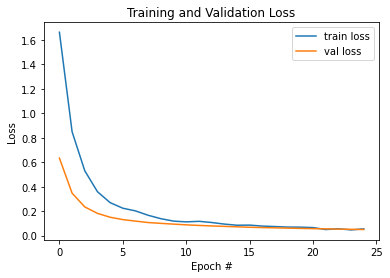

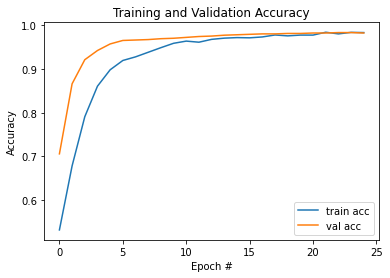

In [16]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.savefig(r"plots\densenet121\loss_plot.png")
plt.legend()
plt.show()

plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.savefig(r"plots\densenet121\accuracy_plot.png")
plt.legend()
plt.show()

In [17]:
model.save(r"models\mask_detector_densenet.model", save_format="h5")

In [18]:
# picking the first FC layer as the features which will be of dimension (1 x 128)
layer_name = 'dense'
FC_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [19]:
# finding the features for n number of train images (n x 128)
i=0
features=np.zeros(shape=(trainX.shape[0],128))
for img in trainX:  
        img = np.expand_dims(img, axis=0)
        features[i] = FC_layer_model.predict(img)
        i+=1

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 27ms/step


In [20]:
np.save(r"utils\features_densenet121", features)

In [21]:
# naming the feature rows as f_0, f_1
feature_col=[]
for i in range(128):
    feature_col.append("f_"+str(i))
    i+=1

In [22]:
# creating DataFrame with features and coloumn name
train_features = pd.DataFrame(data=features,columns=feature_col)
feature_col = np.array(feature_col)

In [23]:
# feeding the extracted features with the labels to RANDOM FOREST 
rf = RandomForestClassifier(n_estimators = 60, random_state=42, max_features=64)
rf.fit(train_features, trainY)

RandomForestClassifier(max_features=64, n_estimators=60, random_state=42)

In [25]:
# finding the Features from DenseNet121's FC layer for n number of test images (n x 128)
i=0
features_test=np.zeros(shape=(testX.shape[0],128))
for img in testX:
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features_test[i] = FC_output
        i+=1

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


In [26]:
# creating DataFrame with features and coloumn name
test_features=pd.DataFrame(data=features_test,columns=feature_col)
feature_col = np.array(feature_col)

In [27]:
# feeding the features of the test images to Random Forest Classifier to predict its class
predictions = rf.predict(test_features)

Accuracy = 98.800


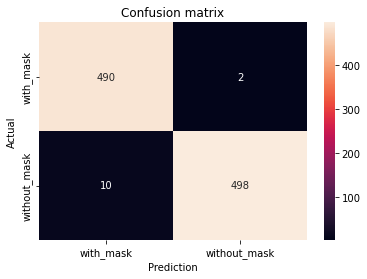

In [28]:
# printing overall accuracy and confusion matrix of DenseNet121+RF
print ("Accuracy = %.3f" % (accuracy_score(predictions[:,1], testY[:,1])*100))
cm = confusion_matrix(predictions[:,1], testY[:,1])
sns.heatmap(cm, fmt='d', annot=True, xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

AUC score: 0.988


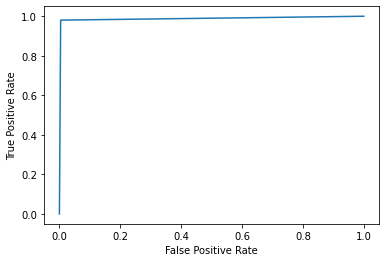

In [29]:
fpr, tpr, thresholds = roc_curve(predictions[:,1], testY[:,1])
print("AUC score: %.3f" % roc_auc_score(predictions[:,1], testY[:,1]))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

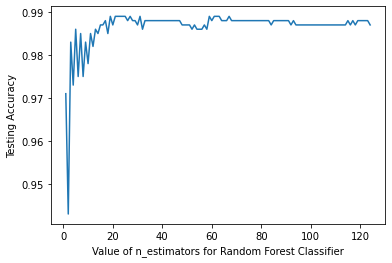

In [30]:
scores = []
for k in range(1, 125):    
    rf = RandomForestClassifier(n_estimators = k, random_state=42, max_features=64)
    rf.fit(train_features, trainY)
    
    test_features=pd.DataFrame(data=features_test,columns=feature_col)
    feature_col = np.array(feature_col)
    
    predictions = rf.predict(test_features)

    scores.append(accuracy_score(predictions, testY))

plt.plot(range(1, 125), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 31ms/step
The prediction for this image is:  ['without_mask']
The actual label for this image is:  ['without_mask']


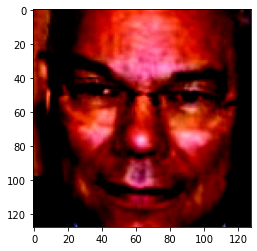

In [31]:
import random
n = random.randint(0, len(testY))
img = testX[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) 
feature = FC_layer_model.predict(input_img)
prediction = rf.predict(feature)
print("The prediction for this image is: ", lb.inverse_transform(np.argmax(prediction)))
print("The actual label for this image is: ", lb.inverse_transform(np.argmax(testY[n])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step
The prediction for this image is:  ['with_mask']
The actual label for this image is:  ['with_mask']


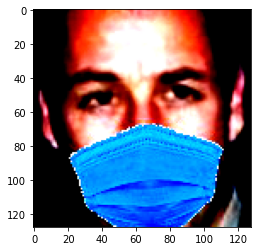

In [32]:
n = random.randint(0, len(testY))
img = testX[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) 
feature = FC_layer_model.predict(input_img)
prediction = rf.predict(feature)
print("The prediction for this image is: ", lb.inverse_transform(np.argmax(prediction)))
print("The actual label for this image is: ", lb.inverse_transform(np.argmax(testY[n])))

1/1 [==============================] - 0s 29ms/step
The prediction for this image is:  ['without_mask']


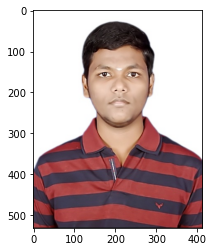

In [33]:
face_cascade = cv2.CascadeClassifier(r"C:\Users\adityakumarbisoyi\Desktop\26177 - No Face Mask Detection using Deep Learning\haarcascades\haarcascade_frontalface_default.xml")
img_path = r"C:\Users\adityakumarbisoyi\Desktop\26177 - No Face Mask Detection using Deep Learning\test_images\test_image_3.jpeg"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
for (x,y,w,h) in faces:
    cropped_face = img[y:y+h, x:x+w]
    resized = cv2.resize(cropped_face, (128,128))
    resized = np.expand_dims(resized, axis=0)
    feature = FC_layer_model.predict(resized) 
    prediction = rf.predict(feature)
    print("The prediction for this image is: ", lb.inverse_transform(np.argmax(prediction)))
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

1/1 [==============================] - 0s 29ms/step
The prediction for this image is:  ['without_mask']


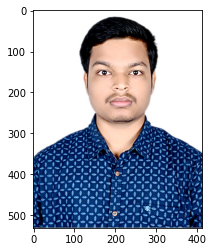

In [34]:
face_cascade = cv2.CascadeClassifier(r"C:\Users\adityakumarbisoyi\Desktop\26177 - No Face Mask Detection using Deep Learning\haarcascades\haarcascade_frontalface_default.xml")
img_path = r"C:\Users\adityakumarbisoyi\Desktop\26177 - No Face Mask Detection using Deep Learning\test_images\test_image_2.jpeg"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
for (x,y,w,h) in faces:
    cropped_face = img[y:y+h, x:x+w]
    resized = cv2.resize(cropped_face, (128,128))
    resized = np.expand_dims(resized, axis=0)
    feature = FC_layer_model.predict(resized) 
    prediction = rf.predict(feature)
    print("The prediction for this image is: ", lb.inverse_transform(np.argmax(prediction)))
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

1/1 [==============================] - 0s 28ms/step
The prediction for this image is:  ['with_mask']


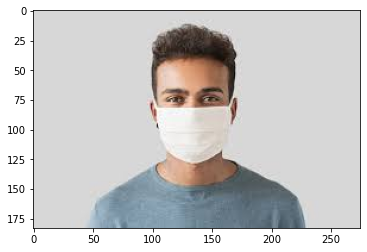

In [35]:
face_cascade = cv2.CascadeClassifier(r"C:\Users\adityakumarbisoyi\Desktop\major_project\haarcascades\haarcascade_frontalface_default.xml")
img_path=r"C:\Users\adityakumarbisoyi\Desktop\major_project\images\img (17).jpg"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)

for (x,y,w,h) in faces:
    cropped_face = img[y:y+h, x:x+w]
    resized = cv2.resize(cropped_face, (128,128))

    resized = np.expand_dims(resized, axis=0)
    feature = FC_layer_model.predict(resized) 
    prediction = rf.predict(feature)    
    print("The prediction for this image is: ", lb.inverse_transform(np.argmax(prediction)))
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

1/1 [==============================] - 0s 32ms/step
The prediction for this image is:  ['with_mask']


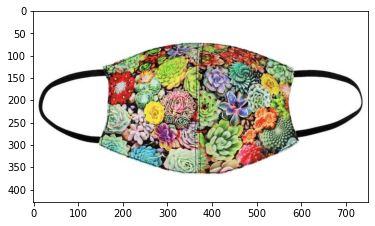

In [36]:
img_path = r"C:\Users\adityakumarbisoyi\Desktop\26177 - No Face Mask Detection using Deep Learning\test_images\test_image_5.jpg"
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
img = cv2.resize(img, (128, 128))
input_img = np.expand_dims(img, axis=0) 
feature = FC_layer_model.predict(input_img)
prediction = rf.predict(feature)
print("The prediction for this image is: ", lb.inverse_transform(prediction[0][1]))